In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats as ss
from autograd.misc import flatten
from autograd.misc.optimizers import adam
from tqdm import trange, tqdm, tqdm_notebook

from autograd import grad
import matplotlib.pyplot as plt

In [2]:
npr.seed(1234)

Code by based on https://github.com/XanderJC/transductive_dropout

In this problem setting we are interested in the case given two data sets, a labelled $\mathcal{D}_{Train} = \{(\mathbf{x}_i,y_i)\}_{i=1}^n$ and an unlabelled  $\mathcal{D}_{Target} = \{\mathbf{x}_j\}_{j=n+1}^{n+m}$, with $\mathbf{x} \in \mathbb{R}$, a $1$-dimensional feature,  and $y \in \mathbb{R}$, a real-valued output, assuming an underlying generative process: 

$$
(X_i,Y_i) \in \mathcal{D}_{Train} \overset{i.i.d.}{\sim} P = P_X \times P_{Y|X}
$$
$$
X_j \in \mathcal{D}_{Target} \overset{i.i.d.}{\sim} Q_X
$$

We first set up our synthetic example data, where both $P_X$ and $Q_X$ will take the form of Normal distributions, and $P_{Y|X} = \mathcal{N}(f(\mathbf{x}),\sigma^2)$, i.e. $Y$ is some deterministic function of $X$ corrupted by some Gaussian noise.

In [3]:
class feature_dist():
    '''
    Just a little class to wrap the behaviour of the distrbutions over
    features. Defines a Gaussian distribution, allows for pdf evaluation 
    and sampling.
    '''
    def __init__(self,mean=0,sd=1):
        self.mean = mean 
        self.sd = sd
    
    def pdf(self,x):
        return(ss.norm.pdf(x,loc=self.mean,scale=self.sd))
    
    def sample(self,num):
        return npr.normal(loc=self.mean,scale=self.sd,size = (num,1))

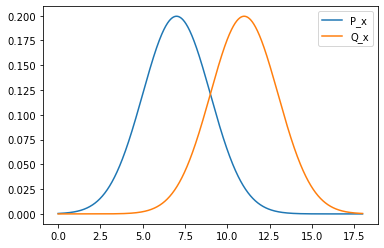

In [4]:
P_x = feature_dist(7,2)
Q_x = feature_dist(11,2)

x = np.linspace(0, 18,1000)

pdf_p = P_x.pdf(x)
pdf_q = Q_x.pdf(x)

plt.plot(x,pdf_p, label = 'P_x')
plt.plot(x,pdf_q, label = 'Q_x')
plt.legend()
plt.show()

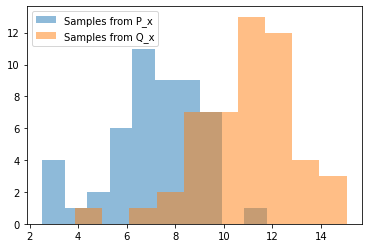

In [5]:
num_samples = 50

samples_p = P_x.sample(num_samples)
samples_q = Q_x.sample(num_samples)

plt.hist(samples_p, alpha = 0.5, label = 'Samples from P_x')
plt.hist(samples_q, alpha = 0.5, label = 'Samples from Q_x')
plt.legend()
plt.show()

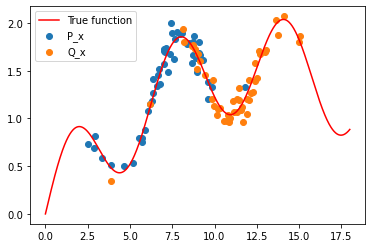

In [6]:
def y_target(x):
    return np.sin(x)/2 + x/4 - x**2/100

def y_noise(n,sd):
    return npr.normal(loc=0,scale=sd,size=(n,1))


y_samples_p = y_target(samples_p) + y_noise(num_samples, 0.1)
y_samples_q = y_target(samples_q) + y_noise(num_samples, 0.1)
true_func = y_target(x)

plt.scatter(samples_p,y_samples_p, label = 'P_x')
plt.scatter(samples_q,y_samples_q, label = 'Q_x')

plt.plot(x, true_func, c = 'r', label = 'True function')

plt.legend()
plt.show()
    

In [7]:
from models import transductive, mc_dropout_concrete
from utils import nice_plot, nice_plot_conc

Optimising parameters: 100%|██████████| 10000/10000 [00:47<00:00, 211.51it/s]


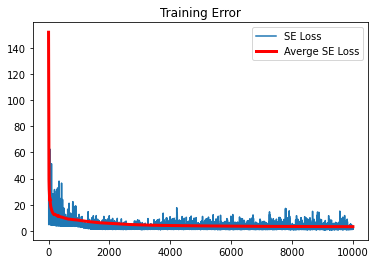

In [8]:
model_concrete = mc_dropout_concrete([1,32,64,1],d_rate = [0.5,0.5,0.5])
model_concrete.train(samples_p, y_samples_p, 10000)

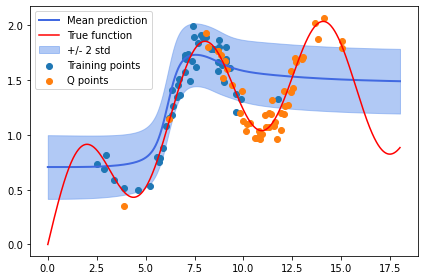

In [9]:
nice_plot_conc(model_concrete,samples_p,y_samples_p,samples_q,y_samples_q,true_func)

In [ ]:
model = transductive([1,32,64,1],d_units = 8)
model.train(samples_p, y_samples_p, samples_q, 1000)

In [ ]:
nice_plot(model,samples_p,y_samples_p,samples_q,y_samples_q,true_func)

# Introducing a mixed distribution in the source domain

We consider two data sets, a labelled $\mathcal{D}_{Train} = \{(\mathbf{x}_i,y_i)\}_{i=1}^n$ and an unlabelled  $\mathcal{D}_{Target} = \{\mathbf{x}_j\}_{j=n+1}^{n+m}$, with $\mathbf{x} \in \mathbb{R}$, a $1$-dimensional feature vector,  and $y \in \mathbb{R}$, a real-valued output, assuming an underlying generative process: 

$$
(x_i,y_i) \in \mathcal{D}_{Train} \overset{i.i.d.}{\sim} P = P_X \times P_{Y|X}
$$


$$
x_j \in \mathcal{D}_{Target} \overset{i.i.d.}{\sim} Q_X
$$


$Q_X$ will take the form of Normal distributions, while $P_X(x) = \sum_{i=1}^{K}\pi_{k} \cdot \mathcal{N}(\mu_k,\sigma_{k}^{2})$

More Specifically, The features $x$ of the source dataset is generated from a Gaussian Mixture distribution 
$$
X_{Source} = \Pi_{i=1}^{3}X_i^{w_k}
$$

$w$ is a 3-dimensional binary random variable with only one element $w_k$  equal to 1 and the others are all $0$.

We first set up our synthetic example data. We sample 150 samples from each of the source and target distributions, to allow enough points to be sampled from all Gaussians in the mixed distribution. Then the labels are generated as: 
$$
Y=f(x)+\epsilon,  f(x)=\frac{\sin(x)}{2}+\frac{x}{4}+\frac{x^2}{100}\\
\epsilon \sim N(0,0.1)
$$ 
That is, $Y$ is some deterministic function of $X$ corrupted by some Gaussian noise.
i.e,  $P_{Y|X} = \mathcal{N}(f(\mathbf{x}),\sigma^2)$. 

Our specific experiment is as follows:
$$
X_1 \sim N(5,2),\, X_2 \sim N(7,2),\, X_1 \sim N(15,2)
$$
$$
p(w_1=1)=0.3,\,p(w_2=1)=0.5,\,p(w_3=1)=0.2
$$
(i.e., $p(w)=(0,1,0)=p(w_2=1)=0.5$).

The features of the target data set is generated from a Gaussian distribution $N(11,2)$.

In [11]:
import numpy as np
import numpy.random
import scipy.stats as ss
import matplotlib.pyplot as plt

# Set-up.
n = 10000
numpy.random.seed(0x5eed)
# Parameters of the mixture components
norm_params = np.array([[5, 1],
                        [1, 1.3],
                        [9, 1.3]])
n_components = norm_params.shape[0]
# Weight of each component, in this case all of them are 1/3
weights = np.ones(n_components, dtype=np.float64) / 3.0
# A stream of indices from which to choose the component
mixture_idx = numpy.random.choice(len(weights), size=n, replace=True, p=weights)
# y is the mixture sample
y = numpy.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                   dtype=np.float64)

# Theoretical PDF plotting -- generate the x and y plotting positions
xs = np.linspace(y.min(), y.max(), 200)
ys = np.zeros_like(xs)

for (l, s), w in zip(norm_params, weights):
    ys += ss.norm.pdf(xs, loc=l, scale=s) * w

# plt.plot(xs, ys)
# plt.hist(y, normed=True, bins="fd")
# plt.xlabel("x")
# plt.ylabel("f(x)")
# plt.show()

In [12]:
class feature_multi_dist():
    '''
    Class that defines a Gaussian distribution and allows for pdf evaluation 
    and sampling.
    '''
    def __init__(self,means,sds,weights):
        
        self.means = means 
        self.sds = sds
        self.weights = weights
        self.params = np.array([means,sds,weights]).T
    
    def pdf(self,x):
        pdf_x = sum([ss.norm.pdf(x, loc=par[0], scale=par[1]) * par[2] for par in self.params])
        return pdf_x
    
    def sample(self,num):
        # A stream of indices from which to choose the component
        mixture_idx = numpy.random.choice(
            len(self.weights), size=num, replace=True, p=self.weights)
        # y is the mixture sample
        y = numpy.fromiter((ss.norm.rvs(*(self.params[:,:-1][i])) for i in mixture_idx),
                   dtype=np.float64)
        
        return np.expand_dims(y,1)
    

In [13]:
means = [5, 7, 15]
sds = [2, 2, 2]
weights = [0.3, 0.5, 0.2]
num = 10000

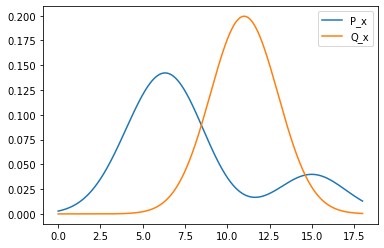

In [14]:
P_x = feature_multi_dist(means,sds,weights)
Q_x = feature_dist(11,2)

x = np.linspace(0, 18,1000)

pdf_p = P_x.pdf(x)
pdf_q = Q_x.pdf(x)

plt.plot(x,pdf_p, label = 'P_x')
plt.plot(x,pdf_q, label = 'Q_x')
plt.legend()
plt.show()

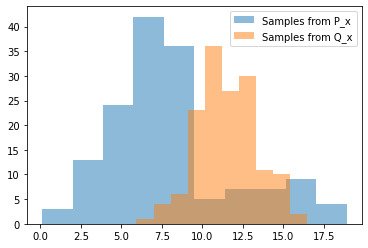

In [15]:
num_samples = 150

samples_p = P_x.sample(num_samples)
samples_q = Q_x.sample(num_samples)

plt.hist(samples_p, alpha = 0.5, label = 'Samples from P_x')
plt.hist(samples_q, alpha = 0.5, label = 'Samples from Q_x')
plt.legend()
plt.show()

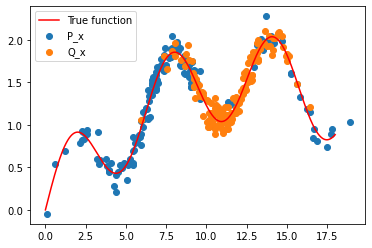

In [16]:
def y_target(x):
    return np.sin(x)/2 + x/4 - x**2/100

def y_noise(n,sd):
    return npr.normal(loc=0,scale=sd,size=(n,1))   

y_samples_p = y_target(samples_p) + y_noise(num_samples, 0.1)
y_samples_q = y_target(samples_q) + y_noise(num_samples, 0.1)
true_func = y_target(x)

plt.scatter(samples_p,y_samples_p, label = 'P_x')
plt.scatter(samples_q,y_samples_q, label = 'Q_x')
plt.plot(x, true_func, c = 'r', label = 'True function')

plt.legend()
plt.show()

In [17]:
from models import transductive, mc_dropout_concrete
from utils import nice_plot, nice_plot_conc

Optimising parameters: 100%|██████████| 10000/10000 [00:49<00:00, 203.35it/s]


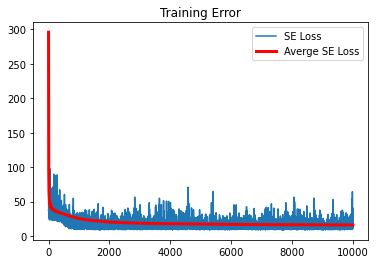

In [18]:
model_concrete = mc_dropout_concrete([1,32,64,1],d_rate = [0.5,0.5,0.5])
model_concrete.train(samples_p, y_samples_p, 10000)

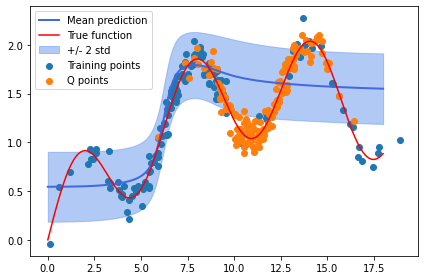

In [19]:
nice_plot_conc(model_concrete,samples_p,y_samples_p,samples_q,y_samples_q,true_func)

Optimising parameters: 100%|██████████| 1000/1000 [5:04:10<00:00, 18.25s/it] 


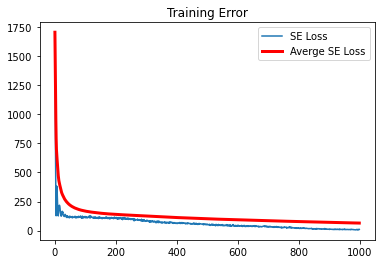

In [20]:
model = transductive([1,32,64,1],d_units = 8)
model.train(samples_p, y_samples_p, samples_q, 1000)

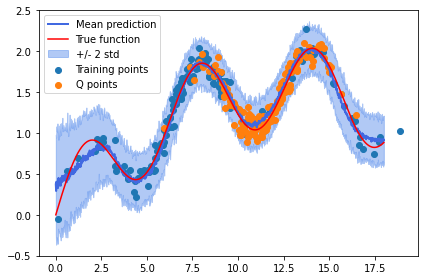

In [21]:
nice_plot(model,samples_p,y_samples_p,samples_q,y_samples_q,true_func)

In [50]:
import autograd.numpy as np
import matplotlib.pyplot as plt

def nice_plot(ax, model,samples_p,y_samples_p,samples_q,y_samples_q,true_func,save = None,params=None):
    '''
    Creates nice plot of predictive distribution given a model.
    '''
    x = np.linspace(0, 18,1000)
    if params:
        model.params = params 
    ns =100
    sample = []
    for _ in range(ns):
        y = model.forward_pass2(model.params,np.reshape(x,(1000,1)))
        sample.append(y)
    sample = np.array(sample)
    sample = np.reshape(sample,(ns,1000))
    s_mean = sample.mean(axis=0)
    s_sd = sample.std(axis=0)

    ax.plot(x, s_mean, linewidth=2, c='royalblue', label='Mean prediction')
    ax.fill_between(np.reshape(x,(1000)), (s_mean - 2 * s_sd), (s_mean + 2 * s_sd),\
        color='cornflowerblue', alpha=.5, label='+/- 2 std')
    ax.scatter(samples_p,y_samples_p, label = 'Training points')
    ax.plot(x, true_func, c = 'r', label = 'True function')
    ax.scatter(samples_q,y_samples_q, label = 'Q points')



def nice_plot_conc(ax, model,samples_p,y_samples_p,samples_q,y_samples_q,true_func):
    '''
    Creates nice plot of predictive distribution given a model. Optionally
    pass a new dropout rate to be used.
    '''
    x = np.linspace(0, 18,1000)
    ns =100
    sample = []
    for _ in range(ns):
        y = model.forward_pass(model.params,np.reshape(x,(1000,1)))
        sample.append(y)
    sample = np.array(sample)
    sample = np.reshape(sample,(ns,1000))
    s_mean = sample.mean(axis=0)
    s_sd = sample.std(axis=0)

    ax.plot(x, s_mean, linewidth=2, c='royalblue', label='Mean prediction')
    ax.fill_between(np.reshape(x,(1000)), (s_mean - 2 * s_sd), (s_mean + 2 * s_sd),\
        color='cornflowerblue', alpha=.5, label='+/- 2 std')
    ax.scatter(samples_p,y_samples_p, label = 'Training points')
    ax.plot(x, true_func, c = 'r', label = 'True function')
    ax.scatter(samples_q,y_samples_q, label = 'Q points')

def plot_combined(model_vds, model_yg,samples_p,y_samples_p,samples_q,
                  y_samples_q,true_func,save = None,params=None):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    
    nice_plot(axes[1],model_vds,samples_p,y_samples_p,samples_q,y_samples_q,true_func)
    nice_plot_conc(axes[0],model_yg,samples_p,y_samples_p,samples_q,y_samples_q,true_func)
    
    fig.align_ylabels(axes)
    
    plt.legend(loc='upper left')
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()


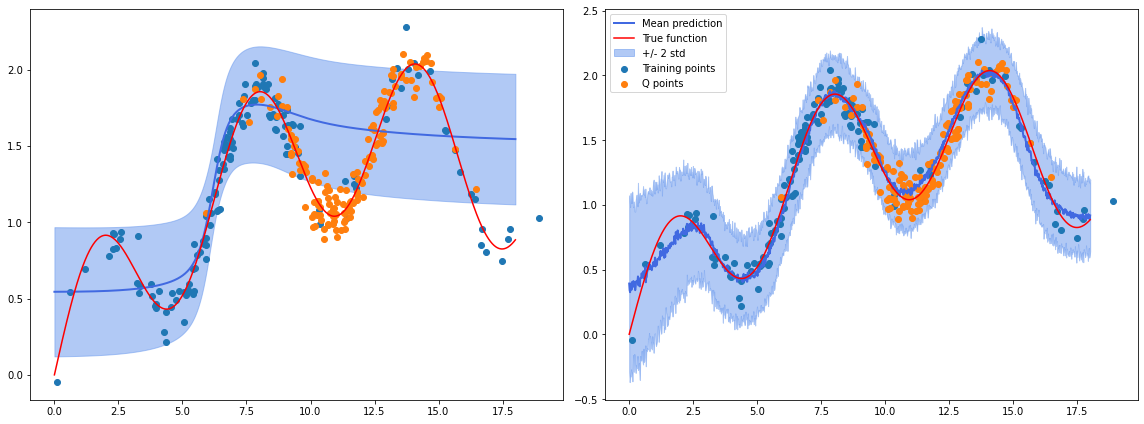

In [51]:
plot_combined(model, model_concrete,samples_p,y_samples_p,samples_q,
                  y_samples_q,true_func,save = None,params=None)

# multidimensional_response_surface

### samples

In [5]:
a1_x = feature_dist(7,2)
a2_x = feature_dist(7,2)

b1_x = feature_dist(11,2)
b2_x = feature_dist(11,2)

x = np.linspace(0, 18,1000)
num_samples = 150

samples_a1 = a1_x.sample(num_samples)
samples_a2 = a2_x.sample(num_samples)
sample_aa = np.squeeze(np.array([samples_a1,samples_a2]))

samples_b1 = b1_x.sample(num_samples)
samples_b2 = b2_x.sample(num_samples)
sample_bb = np.squeeze(np.array([samples_b1,samples_b2]))

# 2 experiment

In [6]:
def y1_target(x1,x2):
    return np.sin(np.sqrt(x1 ** 2 + x2 ** 2))

def y2_target(x1,x2):
    return np.cos(np.sqrt(x1 ** 2 + x2 ** 2))

def y_target_d2_ind(x1,x2):
    return np.squeeze(np.array([y1_target(x1,x2),y2_target(x1,x2)]))

def y_noise(n,sd):
    return npr.normal(loc=0,scale=sd,size=(n,1))

### output samples

In [7]:
y_a = y_target_d2_ind(samples_a1,samples_a2)
y_samples_a1 = np.reshape(y_a[0],(150,1)) + y_noise(num_samples, 0.1)
y_samples_a2 = np.reshape(y_a[1],(150,1)) + y_noise(num_samples, 0.1)
y_samples_a = np.squeeze(np.array([y_samples_a1,y_samples_a2])).T

y_b = y_target_d2_ind(samples_b1,samples_b2)
y_samples_b1 = np.reshape(y_b[0],(150,1)) + y_noise(num_samples, 0.1)
y_samples_b2 = np.reshape(y_b[1],(150,1)) + y_noise(num_samples, 0.1)
y_samples_b = np.squeeze(np.array([y_samples_b1, y_samples_b2])).T

In [8]:
sample_aa = sample_aa.T
sample_bb = sample_bb.T

In [9]:
from models_multivariate_response_surface import transductive, mc_dropout_concrete

In [10]:
model = transductive([2,32,64,2],d_units = 8)

Optimising parameters: 100%|██████████| 1000/1000 [9:09:55<00:00, 33.00s/it]     


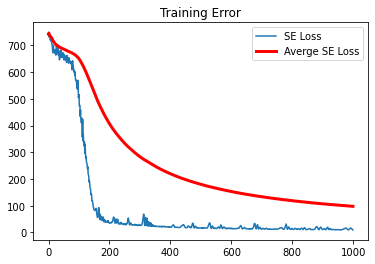

In [11]:
model.train(sample_aa, y_samples_a, sample_bb, 1000)

# 3 experiment

In [12]:
def y2_target(x1,x2):
    return np.sin(np.sqrt(x1 ** 2 + x2 ** 2))

### output samples

In [13]:
qy_a = y_target_d2_ind(samples_a1,samples_a2)
qy_samples_a1 = np.reshape(qy_a[0],(150,1)) + y_noise(num_samples, 0.1)
qy_samples_a2 = np.reshape(qy_a[1],(150,1)) + y_noise(num_samples, 0.1)
qy_samples_a = np.squeeze(np.array([qy_samples_a1,qy_samples_a2])).T

qy_b = y_target_d2_ind(samples_b1,samples_b2)
qy_samples_b1 = np.reshape(qy_b[0],(150,1)) + y_noise(num_samples, 0.1)
qy_samples_b2 = np.reshape(qy_b[1],(150,1)) + y_noise(num_samples, 0.1)
qy_samples_b = np.squeeze(np.array([qy_samples_b1, qy_samples_b2])).T

In [14]:
model2 = transductive([2,32,64,2],d_units = 8)

Optimising parameters: 100%|██████████| 1000/1000 [6:53:26<00:00, 24.81s/it] 


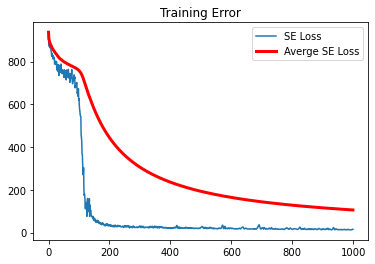

In [15]:
model2.train(sample_aa, qy_samples_a, sample_bb, 1000)

# Plots

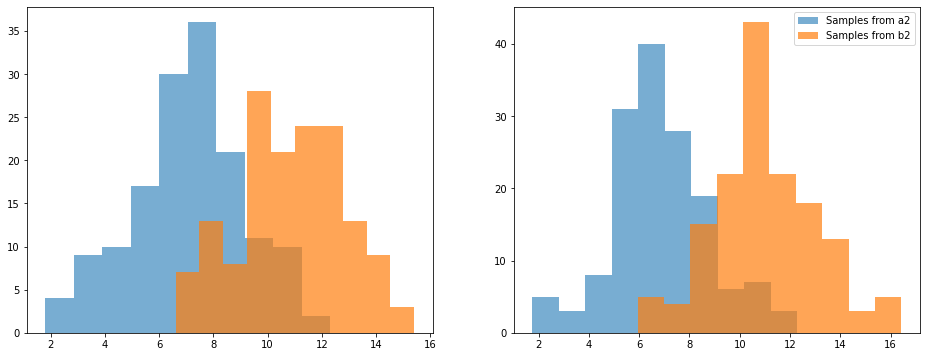

In [109]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

axes[0].hist(samples_a1, alpha = 0.6, label = 'Samples from a1')
axes[0].hist(samples_b1, alpha = 0.7, label = 'Samples from b1')
axes[1].hist(samples_a2, alpha = 0.6, label = 'Samples from a2')
axes[1].hist(samples_b2, alpha = 0.7, label = 'Samples from b2')
plt.legend()
plt.show()

In [ ]:
plt.scatter(samples_p,y_samples_p, label = 'P_x')
plt.scatter(samples_q,y_samples_q, label = 'Q_x')
plt.plot(x, true_func, c = 'r', label = 'True function')

plt.legend()
plt.show()

In [91]:
def y1_target(x1,x2):
    return np.sin(np.sqrt(x1 ** 2 + x2 ** 2))

In [97]:
x = np.linspace(0, 18, 150)
y = np.linspace(-3, 18, 150)

X, Y = np.meshgrid(x, y)
Z = y1_target(X, Y)

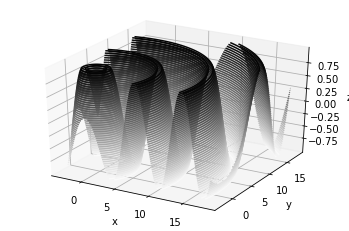

In [98]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
# ax.scatter3D(x, y, Z, c=zdata, cmap='Blues_r');

In [68]:
def y_2d_model_samples(n, model):
    x = np.linspace(-3, 18,n)
    xx = np.squeeze(np.array([x,x])).T
    sample = []
    for _ in range(100):
        y = model.forward_pass2(model.params,xx)
        sample.append(y)
    sample = np.array(sample)

    return sample

In [69]:
sample_test = y_2d_model_samples(n, model)

In [70]:
sample_test1 = sample_test[:,:,0]
s_mean = sample_test1.mean(axis=0)

In [ ]:
x = np.linspace(-3, 18, 150)
y = np.linspace(-3, 18, 150)

X, Y = np.meshgrid(x, y)
Z = y1_target(X, Y)


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

ax.scatter3D(x, y, y_samples_a1, c=y_samples_a1, cmap='Blues_r');

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


In [53]:
def nice_plot_2d(ax, model_ya,samples_a1 samples_a2,samples_a1,
                 samples_b1,samples_b2,y_samples_b,true_func,
                 save = None,params=None):
    '''
    Creates nice plot of predictive distribution given a model.
    '''
    n = model_yi.shape[0]
    x = np.linspace(0, 18,1000)
    s_mean = model_ya.mean(axis=0)
    s_sd = model_ya.std(axis=0)
    
    

    ax.plot(x, s_mean, linewidth=2, c='royalblue', label='Mean prediction')
    ax.fill_between(np.reshape(x,(1000)), (s_mean - 2 * s_sd), (s_mean + 2 * s_sd),\
        color='cornflowerblue', alpha=.5, label='+/- 2 std')
    ax.scatter(samples_p,y_samples_p, label = 'Training points')
    ax.plot(x, true_func, c = 'r', label = 'True function')
    ax.scatter(samples_q,y_samples_q, label = 'Q points')

In [55]:
def plot_combined_dimensions(n, model,samples_a1,y_samples_a1,
                             samples_a2,y_samples_a2, 
                             samples_b1, y_samples_b1,
                             samples_b2, y_samples_b2,
                             true_func1,true_func2,
                             save = None,params=None):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    
    sample = y_2d_model_samples(n, model)
    
    
    nice_plot_2d(axes[0], sample[:,:,0],samples_a1,y_samples_a1,
                 samples_b1,y_samples_b1,true_func1,
                 save = None,params=None)
    nice_plot_2d(axes[1], sample[:,:,1],samples_a2,y_samples_a2,
             samples_b2,y_samples_b2,true_func2,
             save = None,params=None)
    
    fig.align_ylabels(axes)
    
    plt.legend(loc='upper left')
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()

## Plot experiment 1

In [57]:
def true_func1(x1,x2):
    return np.sin(np.sqrt(x1 ** 2 + x2 ** 2))

def true_func2(x1,x2):
    return np.cos(np.sqrt(x1 ** 2 + x2 ** 2))

In [ ]:
plot_combined_dimensions(n, model,samples_a1,y_samples_a1,
                             samples_a2,y_samples_a2, 
                             samples_b1, y_samples_b1,
                             samples_b2, y_samples_b2,
                             true_func1,true_func2,
                             save = None,params=None)